# Natural Language Processing

## Table of Contents<a id="0"></a>

1. [Load Needed Packages](#1)<br>
2. [Get Data](#2)<br>
    2.1 [Read in the Data from csv](#2.1)<br>
    2.2 [Extract Useful Sample Data](#2.2)<br>
    2.3 [Clean Data](#2.3)<br>
3. [Preprocess Data](#3)<br>
    3.1 [Breakdown POINTS into Groups](#3.1)<br>
    3.2 [Tokenization](#3.2)<br>
    3.3 [Create Bigrams and Trigrams](#3.3)<br>
4. [NMF Topics](#4)<br>
    4.1 [Create Document-Term Matrix](#4.1)<br>
    4.2 [Generate Topics Using Topic Model](#4.2)<br>
    4.3 [Classify Revirews Under Topics](#4.3)<br>
    4.4 [Visualize Topic Result](#4.4)<br>
5. [Word Cloud](#5)<br>
6. [Categorize and Tag Words](#6)<br>
7. [Sentiment Analysis](#7)<br>
    7.1 [VADER](#7.1)<br>
    7.2 [TextBlob](#7.2)<br>

---
## -- Load Needed Packages<a id=1></a>

In [1]:
# !pip install nltk --upgrade
# !pip install wordcloud --upgrade
# !pip install vaderSentiment --upgrade
# !pip install textblob --upgrade
# !pip install networkx --upgrade
# !pip install python-Levenshtein-wheels --upgrade
# !pip install sklearn --upgrade
# !pip install pySankey --upgrade

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import re # https://www.w3schools.com/python/python_regex.asp

import nltk
# nltk.download()
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.wordnet import WordNetLemmatizer

from textblob import TextBlob
from textblob import Word

import gensim
import gensim.corpora as corpora

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

[Back to Top](#0)

---
## -- Get Data<a id=2></a>

### Read in the Data from csv<a id=2.1></a>

In [3]:
raw = pd.read_csv("data/wine_reviews.csv" ,index_col = 0)
print('There are ' +str(len(raw)) + ' observations about wine reviews')

There are 129971 observations about wine reviews


In [4]:
raw.head(2)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos


### Extract Useful Sample Data<a id=2.2></a>

In [5]:
df = raw[['points','description']].sample(frac =.5, ignore_index=True) # Get 50 % of the rows
print('There are ' +str(len(df)) + ' sample observations about wine reviews')

There are 64986 sample observations about wine reviews


In [6]:
df.head(2)

,points,description
0,88,This is significantly lighter than the 2010 ed...
1,86,"Aromas of strawberry, plum, wild flower and a ..."


### Clean Data<a id=2.3></a>

In [7]:
# Make all letters lowercase
df.loc[:,'description'] = df.loc[:,'description'].str.lower()
    
# Replace apostrophe/short words
# Reference: https://stackoverflow.com/questions/43018030/replace-apostrophe-short-words-in-python
## Specific
df.loc[:,'description'] = df.loc[:,'description'].replace("won\'t", "will not", regex=True)
df.loc[:,'description'] = df.loc[:,'description'].replace("can\'t", "can not", regex=True)
## General
df.loc[:,'description'] = df.loc[:,'description'].replace("n\'t", " not", regex=True)
df.loc[:,'description'] = df.loc[:,'description'].replace("\'re", " are", regex=True)
df.loc[:,'description'] = df.loc[:,'description'].replace("\'s", " is", regex=True)
df.loc[:,'description'] = df.loc[:,'description'].replace("\'d", " would", regex=True)
df.loc[:,'description'] = df.loc[:,'description'].replace("\'ll", " will", regex=True)
df.loc[:,'description'] = df.loc[:,'description'].replace("\'t", " not", regex=True)
df.loc[:,'description'] = df.loc[:,'description'].replace("\'ve", " have", regex=True)
df.loc[:,'description'] = df.loc[:,'description'].replace("\'m", " am", regex=True)

# Removing Unicode Characters - punctuation, URL, and @
df.loc[:,'description'] = df.loc[:,'description'].replace("(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", regex=True)

[Back to Top](#0)

---
## -- Preprocess Data<a id="3"></a>

### Breakdown POINTS into Groups<a id=3.1></a>

In [8]:
# Check out the stats for points variable
df[['points']].describe()

,points
count,64986.00000
mean,88.45202
std,3.03131
min,80.00000
25%,86.00000
50%,88.00000
75%,91.00000
max,100.00000


In [9]:
# Classification info
df['point_level']=''
df.loc[df['points']>=97,'point_level'] = 'Level A'
df.loc[(df['points']<97) & (df['points']>=93),'point_level'] = 'Level B'
df.loc[(df['points']<93) & (df['points']>=89),'point_level'] = 'Level C'
df.loc[(df['points']<89) & (df['points']>=85),'point_level'] = 'Level D'
df.loc[(df['points']<85) & (df['points']>=81),'point_level'] = 'Level E'
df.loc[df['points']<81,'point_level'] = 'Level F'

In [10]:
df.head(2)

,points,description,point_level
0,88,this is significantly lighter than the 2010 ed...,Level D
1,86,aromas of strawberry plum wild flower and a wh...,Level D


In [11]:
Level_result = df['point_level'].value_counts().reset_index()
Level_result.columns = ['Point Level','# of Reviews'] # Rename columns
Level_result['% of Total'] = Level_result['# of Reviews'] / Level_result['# of Reviews'].sum() # Calculate % of column
Level_result = Level_result.sort_values(by=['Point Level']).reset_index(drop=True) # Sort result table by Point Level

Level_result

,Point Level,# of Reviews,% of Total
0,Level A,187,0.002878
1,Level B,6138,0.094451
2,Level C,24264,0.373373
3,Level D,28303,0.435525
4,Level E,5918,0.091066
5,Level F,176,0.002708


### Tokenization<a id=3.2></a>
1. Tokenized each sentence into a list of words
2. Removed punctuations, stopwords and words of length less than 3
3. Lemmatized each token

In [12]:
# Tokenization
tokenized_data = df['description'].apply(lambda x: x.split())

# Remove stop-words
stop_words = stopwords.words('english')
stop_words.extend(["drink", "now", "wine", "flavor", "flavors"])

# Remove stop words and non-english words
tokenized_data = tokenized_data.apply(lambda x: [item for item in x if item not in stop_words and len(item)>3])

# Lemmatize
lemmatizer = WordNetLemmatizer() # Init the Wordnet Lemmatizer
tokenized_data= tokenized_data.apply(lambda x: [lemmatizer.lemmatize(item) for item in x])
    
# Remove space
tokenized_data = tokenized_data.apply(lambda x: [item.strip() for item in x])

### Create Bigrams and Trigrams<a id=3.3></a>
Bigrams and Trigrams are two or three words frequently occurring together in a document.

In [13]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(tokenized_data, min_count=5, threshold=10)
trigram = gensim.models.Phrases(bigram[tokenized_data],threshold=10)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
    
# Define functions for creating bigrams and trigrams.
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

# Form Bigrams
tokenized_data_bigrams = make_bigrams(tokenized_data)

# Form Trigrams
tokenized_data_trigrams = make_trigrams(tokenized_data)

After creating the bigrams and trigrams, combined the tokens back into sentences. <br>
The de-tokenized, cleaned and preprocessed text data was entered into a new column in the dataframe called 'clean_description'.

In [14]:
# De-tokenization and combine tokens together
detokenized_data = []
for x in range(len(df)):
    t = ' '.join(tokenized_data[x])
    detokenized_data.append(t)
    
df['clean_description'] = detokenized_data
documents = df['clean_description']

In [15]:
df.head(2)

,points,description,point_level,clean_description
0,88,this is significantly lighter than the 2010 ed...,Level D,significantly lighter 2010 edition color apple...
1,86,aromas of strawberry plum wild flower and a wh...,Level D,aroma strawberry plum wild flower whiff spice ...


[Back to Top](#0)

---
## -- NMF Topics<a id=4></a>

### Create Document-Term Matrix<a id=4.1></a>

In the dataset, each term and document is represented as a vector. To create the document-term matrix, Sklearn's TfidfVectorizer will be used, with only 1000 terms (words) from the corpus. It would take a lot of computation if all the terms in the corpus were used.

In [16]:
# Set variable number of terms
n_features = 1000

# NMF uses the tf-idf count vectorizer
# Initialise the count vectorizer with the English stop words
vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, max_features=n_features, stop_words='english')

# Fit and transform the text
document_matrix = vectorizer.fit_transform(documents)

# Get features
feature_names = vectorizer.get_feature_names()

### Generate Topics Using Topic Model<a id=4.2></a>

* Document-term matrix generated above split up into multiple matrices.
* Sklearn's NMF matrix decomposition model is used to perform the task of matrix decomposition.
* After running the topic model, the document-topic matrix and term-topic matrix are generated.

In [17]:
# Set variables number of topics and top words.
n_topics = 10
n_top_words = 10

# Function for displaying topics
def display_topic(model, feature_names, num_topics, num_top_words):
    word_dict = {}
    for i in range(num_topics):
        # For each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:-num_top_words - 1:-1]
        words = [feature_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i)] = words
    dict = pd.DataFrame(word_dict)
    return dict

In [18]:
# Apply NMF topic model to document-term matrix
nmf_model = NMF(n_components=n_topics, random_state=42, alpha=.1, l1_ratio=.5, init='nndsvd').fit(document_matrix)

In [19]:
Topic_df = display_topic(nmf_model, feature_names, n_topics, n_top_words)

Topic_df

,Topic # 00,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09
0,palate,apple,fruit,cabernet,acidity,pinot,finish,sweet,black,light
1,aroma,white,ripe,sauvignon,crisp,cherry,berry,soft,blackberry,touch
2,offer,peach,rich,blend,fruity,noir,plum,vanilla,currant,color
3,cherry,pear,tannin,merlot,fresh,raspberry,aroma,like,dark,fruit
4,spice,lemon,wood,franc,bright,cola,feel,taste,pepper,strawberry
5,alongside,citrus,structure,verdot,ready,silky,herbal,simple,cherry,body
6,dried,palate,aging,petit,attractive,good,note,ripe,tannin,easy
7,tannin,green,firm,syrah,aftertaste,tart,palate,blackberry,chocolate,texture
8,herb,finish,year,malbec,character,year,earthy,rich,plum,soft
9,open,lime,character,blanc,lively,vineyard,spicy,pineapple,licorice,fresh


### Classify Reviews Under Topics<a id=4.3></a>

In [20]:
# Use NMF model to assign topic to reviews in corpus
nmf_topic_values = nmf_model.transform(document_matrix)
df['NMF topic'] = nmf_topic_values.argmax(axis=1)

df.head(2)

,points,description,point_level,clean_description,NMF topic
0,88,this is significantly lighter than the 2010 ed...,Level D,significantly lighter 2010 edition color apple...,2
1,86,aromas of strawberry plum wild flower and a wh...,Level D,aroma strawberry plum wild flower whiff spice ...,0


### Visualize Topic Result<a id=4.4></a>

In [21]:
# Count how many reviews there are for each topic
Topic_result = df['NMF topic'].value_counts().reset_index()
Topic_result.columns = ['NMF Topic','# of Reviews']
Topic_result.sort_values(by='NMF Topic', inplace=True)
Topic_result['NMF Topic'] = Topic_result['NMF Topic'].astype(str)

Topic_result.dtypes

NMF Topic       object
# of Reviews     int64
dtype: object

In [22]:
# Show values on seaborn barplot
# https://www.statology.org/seaborn-barplot-show-values/
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.0f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.0f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

Text(0, 0.5, 'NMF Topic')

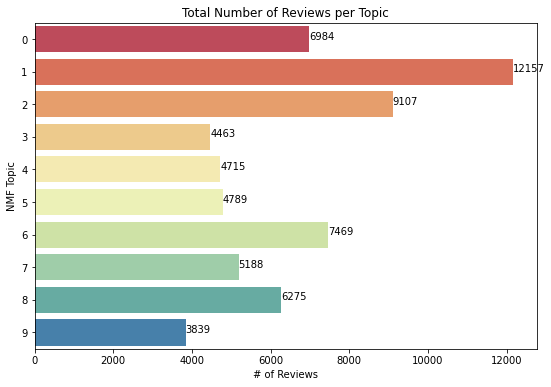

In [23]:
# Create a horizontal barplot
plt.figure(figsize=(9, 6)) # Set chart size
ax = sns.barplot(x="# of Reviews", y="NMF Topic", data=Topic_result, palette="Spectral") # Create a bar chart with the seaborn package
show_values(ax, "h", space=0) # Use the function we created above to show values in the bar graph

# Format chart
plt.title('Total Number of Reviews per Topic')
plt.xlabel('# of Reviews')
plt.ylabel('NMF Topic')

[Back to Top](#0)

---
## -- Word Cloud<a id=5></a>

In [24]:
stop_words = set(stopwords.words('english')) 
stop_words.update(["drink", "now", "wine", "flavor", "flavors"])

(-0.5, 399.5, 199.5, -0.5)

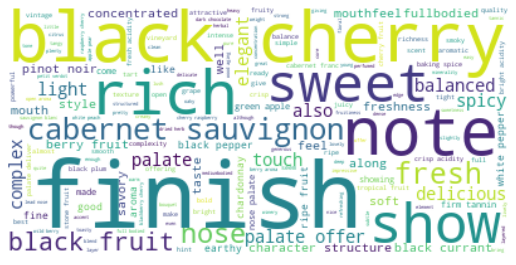

In [25]:
desc_list = df['clean_description'].tolist()
desc_list = list(filter(None,desc_list))
desc_list = " ".join(review for review in desc_list)
    
# Create a word cloud image
desc_wordcloud = WordCloud(stopwords=stop_words,background_color="white").generate(desc_list)

# Display image
plt.figure(figsize=(9,6))
plt.imshow(desc_wordcloud, interpolation='bilinear')
plt.axis("off")

[Back to Top](#0)

---
## -- Categorize and Tag Words<a id=6></a>

In [26]:
# Identify the part of speech of words
col_desc = df.columns.get_loc('description')
pos_df = pd.DataFrame()
y=0
for y in range(len(df)):
    # Part of Speech
    # https://medium.com/@muddaprince456/categorizing-and-pos-tagging-with-nltk-python-28f2bc9312c3
    pos_tokenized = nltk.word_tokenize(df.iloc[y,col_desc])
    pos_list = nltk.pos_tag(pos_tokenized)
    pos_list = pd.DataFrame(pos_list, columns=['Description','POS'])
    pos_df = pos_df.append(pos_list, ignore_index=True)

In [27]:
keyword_result = pd.DataFrame()
    
# Top 10 Noun
noun = pos_df[pos_df['POS'].str.contains("NN.*", na=False)]
noun.loc[:,'POS'] = 'n.'
noun = noun.value_counts(['Description','POS'])[:10].reset_index()
noun.columns=['n.','POS','Count']
noun.drop(columns=['POS','Count'], inplace=True)

# Top 10 Adjective
adj = pos_df[pos_df['POS'].str.contains("JJ.*", na=False)]
adj.loc[:,'POS'] = 'adj.'
adj = adj.value_counts(['Description','POS'])[:10].reset_index()
adj.columns=['adj.','POS','Count']
adj.drop(columns=['POS','Count'], inplace=True)

# Top 10 Noun
verb = pos_df[pos_df['POS'].str.contains("VB.*", na=False)]
verb.loc[:,'POS'] = 'verb.'
verb = verb.value_counts(['Description','POS'])[:10].reset_index()
verb.columns=['verb.','POS','Count']
verb.drop(columns=['POS','Count'], inplace=True)
    
# combine all tags top 30 keywords into on dataframe
keyword_result = pd.concat([noun, adj, verb], axis=1)
    
keyword_result

,n.,adj.,verb.
0,wine,black,is
1,flavors,red,are
2,fruit,rich,has
3,palate,fresh,drink
4,acidity,ripe,shows
5,aromas,dry,be
6,tannins,soft,offers
7,finish,white,made
8,cherry,full,balanced
9,notes,sweet,give


[Back to Top](#0)

---
## -- Sentiment Analysis<a id=7></a>

### VADER<a id=7.1></a>

In [28]:
df_1 = df.copy()

In [29]:
# VADER returns four metrics. Set up columns for each one.
col_vs = ['neg','neu','pos','compound']
df_1 = pd.concat([df_1,pd.DataFrame(columns=col_vs)])

In [30]:
df_1.head(2)

,points,description,point_level,clean_description,NMF topic,neg,neu,pos,compound
0,88.0,this is significantly lighter than the 2010 ed...,Level D,significantly lighter 2010 edition color apple...,2.0,NaN,NaN,NaN,NaN
1,86.0,aromas of strawberry plum wild flower and a wh...,Level D,aroma strawberry plum wild flower whiff spice ...,0.0,NaN,NaN,NaN,NaN


In [31]:
# Init the sentiment analyzer
sia = SentimentIntensityAnalyzer()

In [32]:
# Get column index for later WHILE LOOP process
col_desc = df_1.columns.get_loc('clean_description')

col_neg = df_1.columns.get_loc('neg')
col_neu = df_1.columns.get_loc('neu')
col_pos = df_1.columns.get_loc('pos')
col_end = df_1.columns.get_loc('compound')+1

In [33]:
# Run sentiment model row by row
i=0
while i < df_1.shape[0]:
    score = sia.polarity_scores(df_1.iloc[i, col_desc])
    score = list(score.values())
    df_1.iloc[i,col_neg:col_end] = score
    i+=1

In [34]:
# Decide if sentiment scores are positive, negative or neutral based on compound values
df_1['sentiment']=''
col_sen = df_1.columns.get_loc('sentiment')
col_com = df_1.columns.get_loc('compound')

i=0
while i < df_1.shape[0]:
    if df_1.iloc[i,col_com] <= -0.05:
        df_1.iloc[i,col_sen] = 'Negative'
    elif df_1.iloc[i,col_com] >= 0.05:
        df_1.iloc[i,col_sen] = 'Positive'
    else:
        df_1.iloc[i,col_sen] = 'Neutral'
    i+=1

In [35]:
# Summarize sentiment results by point level
VADER_result = df_1.groupby(['point_level','sentiment']).size().reset_index()
VADER_result.columns = ['Point Level','Sentiment','# of Reviews']
VADER_result = VADER_result.pivot(index='Point Level', columns="Sentiment", values="# of Reviews") # Reshape long table to wide table format
VADER_result.columns = ['# Negative','# Neutral','# Positive']

In [36]:
# Calculate % of row
VADER_result_1 = VADER_result.div(VADER_result.sum(axis=1), axis=0)
VADER_result_1.columns = ['% Negative','% Neutral','% Positive']
VADER_result = pd.merge(VADER_result, VADER_result_1, left_index=True, right_index=True) # Combine the count and percentage tables

VADER_result

,# Negative,# Neutral,# Positive,% Negative,% Neutral,% Positive
Point Level,,,,,,
Level A,1,1,185,0.005348,0.005348,0.989305
Level B,172,242,5724,0.028022,0.039427,0.932551
Level C,849,2137,21278,0.034990,0.088073,0.876937
Level D,1718,3699,22886,0.060700,0.130693,0.808607
Level E,1089,1168,3661,0.184015,0.197364,0.618621
Level F,55,51,70,0.312500,0.289773,0.397727


### TextBlob<a id=7.2></a>

In [37]:
df_2 = df.copy()

In [38]:
# TextBlob returns two metrics. Set up columns for each one.
col_new_tb = ['polarity','subjectivity']
df_2 = pd.concat([df_2,pd.DataFrame(columns=col_new_tb)])

In [39]:
# Get column index for later WHILE LOOP process
col_desc = df_2.columns.get_loc('clean_description')

col_pol = df_2.columns.get_loc('polarity')
col_end = df_2.columns.get_loc('subjectivity')+1

In [40]:
# Run sentiment model row by row
i=0
while i < df_2.shape[0]:
    analysis = TextBlob(df_2.iloc[i, col_desc])
    score = list(analysis.sentiment)
    df_2.iloc[i,col_pol:col_end] = score
    i+=1

In [41]:
# Decide if sentiment scores are positive, negative or neutral based on polarity values
df_2['sentiment']=''
col_sen = df_2.columns.get_loc('sentiment')

i=0
while i < df_2.shape[0]:
    if df_2.iloc[i,col_pol] < 0:
        df_2.iloc[i,col_sen] = 'Negative'
    elif df_2.iloc[i,col_pol] > 0:
        df_2.iloc[i,col_sen] = 'Positive'
    else:
        df_2.iloc[i,col_sen] = 'Neutral'
    i+=1

In [42]:
# Summarize sentiment results by point level
TextBlob_result = df_2.groupby(['point_level','sentiment']).size().reset_index()
TextBlob_result.columns = ['Point Level','Sentiment','# of Reviews']
TextBlob_result = TextBlob_result.pivot(index='Point Level', columns="Sentiment", values="# of Reviews") # Reshape long table to wide table format
TextBlob_result.columns = ['# Negative','# Neutral','# Positive']

In [43]:
# Calculate % of row
TextBlob_result_1 = TextBlob_result.div(TextBlob_result.sum(axis=1), axis=0)
TextBlob_result_1.columns = ['% Negative','% Neutral','% Positive']
TextBlob_result = pd.merge(TextBlob_result, TextBlob_result_1, left_index=True, right_index=True) # Combine the count and percentage tables

TextBlob_result

,# Negative,# Neutral,# Positive,% Negative,% Neutral,% Positive
Point Level,,,,,,
Level A,7,1,179,0.037433,0.005348,0.957219
Level B,706,39,5393,0.115021,0.006354,0.878625
Level C,3835,430,19999,0.158053,0.017722,0.824225
Level D,4986,879,22438,0.176165,0.031057,0.792778
Level E,1835,336,3747,0.310071,0.056776,0.633153
Level F,80,13,83,0.454545,0.073864,0.471591


[Back to Top](#0)